# Connecting To TPU and Preparing The Strategy
In TensorFlow, a Strategy object determines how models and data should be distributed across workers. There is a TPUStrategy specifically for TPU.

In [1]:
import tensorflow as tf

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu) 

D0710 12:27:27.451162550      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0710 12:27:27.451198450      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0710 12:27:27.451201975      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0710 12:27:27.451204671      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0710 12:27:27.451207027      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0710 12:27:27.451209905      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0710 12:27:27.451212560      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0710 12:27:27.

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

# Mixed Precision Training
Mixed precision training is the use of lower-precision operations (float16 and bfloat16) in a model during training to make it run faster and use less memory. Using mixed precision can improve performance by more than 3 times on modern GPUs and 60% on TPUs.
Most models use the float32 dtype, which takes 32 bits of memory. However, there are two lower-precision dtypes, float16 and bfloat16, each which take 16 bits of memory instead which is suitable for modern accelerators as they can run operations faster in the 16-bit dtypes, as they have specialized hardware to run 16-bit computations and 16-bit dtypes can be read from memory faster.

In [ ]:
#tf.keras.mixed_precision.set_global_policy("mixed_bfloat16") # For TPU
# tf.keras.mixed_precision.set_global_policy('mixed_float16') # For GPU 

# Import Dependencies

In [2]:
# Import standard dependencies
import os
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
import PIL
from sklearn.preprocessing import normalize # for normalizing np array to avoid NaN from dividing by 0
import glob

# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization

# Downloading Test Sets

In [ ]:
# # Install gdown
# !pip install gdown > /dev/null
# import gdown
# url = ['1WO5Meh_yAau00Gm2Rz2Pc0SRldLQYigT', '1AoZrZfym5ZhdTyKSxD0qxa7Xrp2Q1ftp', '1-sDn79lTegXRNhFuRnIRsgdU88cBfW6V']


# for i in range(len(url)):
#     gdown.download('https://drive.google.com/uc?export=download&id='+url[i], quiet=False)
# !unzip 'cfp_align_112.zip' > /dev/null
# !unzip 'agedb_align_112.zip' > /dev/null
# !unzip 'lfw_align_112.zip' > /dev/null

# Prepare Training Dataset
The dataset has been converted into TFRecord dataset format.
A parse function is used to convert the examples in TFRecord dataset into the format required for training.
Data augmentation can also be implemented in the function.

In [3]:
num_classes = 85742
total_examples = 5822653

In [4]:
filenames = tf.data.TFRecordDataset.list_files("/kaggle/input/faces-ms1m-refine-v2-112x112-tfrecord/faces_ms1m_refine_v2_112x112-*.tfrecord")
train_ds = tf.data.TFRecordDataset(filenames, num_parallel_reads = tf.data.AUTOTUNE)

# Raw_dataset contains serialized tf.train.Example messages, so we need to parse it.
# Create a description of the features.
feature_description = {'image_raw': tf.io.FixedLenFeature([], tf.string),
                        'label': tf.io.FixedLenFeature([], tf.int64)}

In [5]:
def parse_tfrecord_fn(example):
    example = tf.io.parse_single_example(example, feature_description)
    img = tf.io.decode_jpeg(example["image_raw"])
    img = tf.reshape(img, shape=(112, 112, 3)) 
    img = tf.cast(img, dtype=tf.float32)
    # For EfficientNetV2, by default input preprocessing is included as a part of the model 
    # (as a Rescaling layer)
    # img = img / 127.5 - 1.0     # Range is [-1, 1]
    label = tf.cast(example['label'], dtype=tf.int32)
    return img, label

In [6]:
train_ds = train_ds.map(parse_tfrecord_fn,num_parallel_calls = tf.data.AUTOTUNE)

# Visualizing Some Examples

In [7]:
for img,label in train_ds.take(3):
  print(label)

tf.Tensor(73851, shape=(), dtype=int32)
tf.Tensor(10419, shape=(), dtype=int32)
tf.Tensor(904, shape=(), dtype=int32)


/tmp/ipykernel_15/1108736508.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 3, idx + 1)


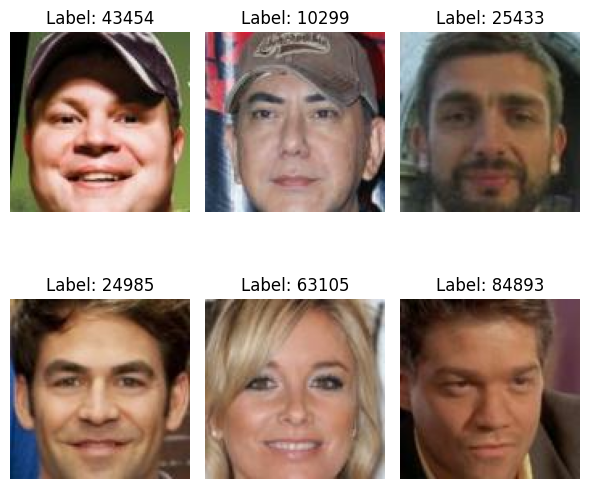

In [8]:
# Plotting first 6 examples

plt.figure(figsize=(6, 6))
plt.axis('off')
for idx, (image, label) in enumerate(train_ds.take(6)):

    ax = plt.subplot(2, 3, idx + 1)
    # Convert image from [-1, 1] range to [0, 1] for plt
    # image = (image + 1.0) / 2.0
    
    # Convert image from [0, 255] range to [0, 1] for plt
    image = image / 255.0
    
    # Plot the image
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
# plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# Configure Dataset For Performance

In [9]:
"""
To train a model with this dataset you will want the data:
  To be well shuffled.
  To be batched.
  Batches to be available as soon as possible.
"""
batch_size_per_replica = 128
global_batch_size = batch_size_per_replica * strategy.num_replicas_in_sync
# global_batch_size = 256
steps_per_epoch = int( np.floor(total_examples/float(global_batch_size)) ) # floor as we will drop remind examples
train_ds = train_ds.repeat().batch(global_batch_size, drop_remainder = True).prefetch(buffer_size = tf.data.AUTOTUNE)
# the training dataset must repeated equal to the number of epochs == train_ds.repeat(num_epochs)

# Building Embedding Model

In [10]:
def build_embedding():
    base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=(112, 112, 3))
#     base_model.trainable = False # Freeze the model
    
#     # Unfreeze the top 20 layers while leaving BatchNorm layers frozen
#     for layer in base_model.layers[-20:]:
#         if not isinstance(layer, BatchNormalization):
#             layer.trainable = True
    
    avg_pool = GlobalAveragePooling2D(name="avg_pool")(base_model.output)  # Pass the output tensor of base_model to GlobalAveragePooling2D
    
    top_dropout_rate = 0.2
    top_dropout = Dropout(top_dropout_rate, name="top_dropout")(avg_pool)
    
    dense_512 = Dense(units=512, activation=None, name="pred")(top_dropout)  # No activation on the final dense layer == linear activation
    embedding = BatchNormalization(momentum=.99, epsilon=.001, scale=True, name="embedding")(dense_512)
    # build the embedding model and return it
    return Model(base_model.input, embedding, name="embedding")

# Building Norm Dense Layer
The best way to implement your own layer is extending the tf.keras.Layer class and implementing:

1. **init**, where you can do all input-independent initialization
2. **build**, where you know the shapes of the input tensors and can do the rest of the initialization
3. **call**, where you do the forward computation

In [11]:
class NormDense(tf.keras.layers.Layer):
    def __init__(self, units=1000, **kwargs):
        super(NormDense, self).__init__(**kwargs)
        self.units = units
        # self.kernel_regularizer
    def build(self, input_shape):
            self.w = self.add_weight(
                name="norm_dense_w",
                shape=(input_shape[-1], self.units),
                initializer=tf.keras.initializers.glorot_normal(), # glorot_uniform()
                trainable=True
            )

    def call(self, inputs, **kwargs):
        
        norm_w = tf.nn.l2_normalize(self.w, axis=0, epsilon=1e-5) # each column is a weight vector
        norm_embedding = tf.nn.l2_normalize(inputs, axis=1, epsilon=1e-5)
        cos_theta = tf.linalg.matmul(norm_embedding, norm_w, name='cos_theta')
        return cos_theta

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

# Defining The Loss Function

In [12]:
class ArcfaceLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes=85742, GLOBAL_BATCH_SIZE = 1024, margin1=1.0, margin2=0.5, margin3=0.0, scale=64.0, **kwargs):
        super(ArcfaceLoss, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.margin1, self.margin2, self.margin3, self.scale = margin1, margin2, margin3, scale
        #self.loss = tf.keras.losses.categorical_crossentropy()
        # self.threshold = np.cos((np.pi - margin2) / margin1)  # grad(theta) == 0
        # self.theta_margin_min = (-1 - margin3) * 2
        self.loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE, from_logits = True) # Linear activation input
        self.GLOBAL_BATCH_SIZE = GLOBAL_BATCH_SIZE
    def call(self, y_true, cos_theta):
        one_hot = tf.one_hot(tf.squeeze(y_true, axis=-1), depth = self.num_classes)
        theta = tf.math.acos(tf.keras.backend.clip(cos_theta, -1.0 + tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon()))
        target_logits = tf.cos(theta * self.margin1 + self.margin2) - self.margin3
        logits = (cos_theta * (1.0 - one_hot) + target_logits * one_hot) * self.scale
        return tf.nn.compute_average_loss(self.loss_obj(one_hot, logits), global_batch_size = self.GLOBAL_BATCH_SIZE)

    def get_config(self):
        config = super(ArcfaceLoss, self).get_config()
        config.update(
            {
                "margin1": self.margin1,
                "margin2": self.margin2,
                "margin3": self.margin3,
                "scale": self.scale
            }
        )
        return config

# Building The Main Model

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=.01, beta_1=0.9, beta_2=0.999, epsilon=0.1) # tfa.optimizers.SGDW(learning_rate=0.1, momentum=0.9, weight_decay=5e-5)
arc_loss = ArcfaceLoss(num_classes = 85742)

In [15]:
with strategy.scope():
    basic_model = build_embedding()
    inputs = basic_model.inputs[0] # Model may have multiple inputs
    embeddings = basic_model.outputs[0] # Model may have multiple outputs
    classification_output_layer = NormDense(units=num_classes)(embeddings)
    
    arcFaceModel = Model(inputs, classification_output_layer)
    
    arcFaceModel.compile(optimizer = opt, loss = arc_loss) #, metrics = ["accuracy"]

24274472/24274472 [==============================] - 0s 0us/step


# Defining Test Evaluation CallBack
Takes the embedding model and the path of the test set and calculate the verification accuracy

In [16]:
class eval_callback(tf.keras.callbacks.Callback):
    def __init__(self, basic_model, test_path, GlobalBatchSize = 1024,flip=True):
        super(eval_callback, self).__init__()
        
        bins , issame = np.load(test_path, encoding="bytes", allow_pickle=True)
        self.test_names = os.path.splitext(os.path.basename(test_path))[0] #To save the name of the test set: LFW or agedb_30...
        self.ds = tf.data.Dataset.from_tensor_slices(bins).map(lambda xx: tf.cast(tf.image.decode_image(xx, channels=3), dtype=tf.float32))\
                       .batch(GlobalBatchSize)
        self.actual_issame = np.array(issame).astype("bool")
        
        self.basic_model = basic_model
        self.max_accuracy, self.best_acc, self.best_threshold = 0.0, 0.0, 0.0
        self.save_model = None # last eval dataset only will change this to save the model one time only
        self.flip = flip
        self.on_epoch_end = lambda epoch=0, logs=None: self.__eval_func__(epoch, logs)
        

    def __do_predict__(self):
        embs = []
        for img_batch in self.ds:
            emb = self.basic_model(img_batch, training=False)
            if self.flip:
                emb_f = self.basic_model(tf.image.flip_left_right(img_batch))
                emb = emb + emb_f
            embs.extend(np.array(emb)) # adding embeddings to the current embeddings list while maintaining correct dimensions
        return np.array(embs)


    def __eval_func__(self, cur_epoch=0, logs=None):
        # print("self.model.params:", self.model.params if self.model else "None")
        cur_epoch = str(cur_epoch + 1)
        dists = []
        tf.print("")
        embs = self.__do_predict__()

        if not np.alltrue(np.isfinite(embs)): # isfinite will return a matrix of booleans. False if the element is infinite
            tf.print("NAN in embs, not a good one")
            return
        
#         ############ For Cosine Similarity
#         embs = normalize(embs) # We normalize the embeddnigs so that the dot product between each 2 images will represent the cosine
#         embs1 = embs[::2]  # will take even indices 
#         embs2 = embs[1::2] # will take odd indices 
#         dists = (embs_a * embs_b).sum(1) # axis=1. summing the rows after multiplying each element in image 1 with the crossponding in image 2
#                                         #=> dot product
        

        ########### For Euclidian distance
        embs = normalize(embs)
        embs1 = embs[::2]  # will take even indices 
        embs2 = embs[1::2] # will take odd indices        
        diff = np.subtract(embs1, embs2)
        dist = np.sum(np.square(diff), 1)

        self.best_threshold = -1
        self.best_acc = 0
        for threshold in np.arange(0, 2.0000111, 0.01): # for cosine: np.arange(-1, 1.0000111, 0.01)
            # predict_issame = np.greater(dist, threshold) # greater for cosine similarity
            predict_issame = np.less(dist, threshold) # less for euclidian distance, 
            tp = np.sum(np.logical_and(predict_issame, self.actual_issame))
#             fp = np.sum(np.logical_and(predict_issame, np.logical_not(self.actual_issame)))
            tn = np.sum(np.logical_and(np.logical_not(predict_issame),
                                       np.logical_not(self.actual_issame)))
#             fn = np.sum(np.logical_and(np.logical_not(predict_issame), self.actual_issame))

#             tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
#             fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
            cur_acc = float(tp + tn) / dist.size
            if cur_acc>self.best_acc:
                self.best_acc = cur_acc
                self.best_threshold = threshold



        tf.print(
            "\n>>>> %s evaluation max accuracy: %f, thresh: %f, previous max accuracy: %f" % (self.test_names, self.best_acc, self.best_threshold, self.max_accuracy)
        )

        if self.best_acc >= self.max_accuracy: #saving the model if we have improving in accuracy
            tf.print(">>>> Improved = %f" % (self.best_acc - self.max_accuracy))
            self.max_accuracy = self.best_acc
            if self.save_model:
                save_name_base = "%s_basic_%s_epoch_" % (self.save_model, self.test_names)
                save_path_base = os.path.join("checkpoints", save_name_base)
                for ii in glob.glob(save_path_base + "*.h5"):
                    os.remove(ii)
                save_path = save_path_base + "%s_%f.h5" % (cur_epoch, self.max_accuracy)
                tf.print("Saving model to: %s" % (save_path))
                self.basic_model.save(save_path, include_optimizer=False) # mostly the model won't be trained again so include_optimizer is false

# Defining NaN Loss CallBack
Stop the training when the loss becomes NaN

In [17]:
class ExitOnNaN(tf.keras.callbacks.Callback):
    """Callback that exit directly when a NaN loss is encountered, avoiding saving model"""

    def __init__(self):
        super().__init__()
        self._supports_tf_logs = True

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get("loss")
        if loss is not None:
            if not tf.math.is_finite(loss):
                print("\nError: Invalid loss, terminating training")
                self.model.stop_training = True

# Defining History CallBack
CallBack for saving loss, accuracy, best threshold.. of each test set based on the evals results from eval callback

In [18]:
class My_history(tf.keras.callbacks.Callback):
    def __init__(self, evals=[]): 
        super(My_history, self).__init__()
        
        self.history = {}
        self.evals = evals # list of objects where each object is a callback for certain test set
        self.custom_obj = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs.pop("lr", None)
        lr = self.model.optimizer.lr
        if hasattr(lr, "value"):
            lr = lr.value()

        self.history.setdefault("lr", []).append(float(lr)) # setdefault if it didn't find lr key it will put its initial value []
        for k, v in logs.items():
            self.history.setdefault(k, []).append(float(v))
        for evalOfOneDataSet in self.evals:
            self.history.setdefault(evalOfOneDataSet.test_names, []).append(float(evalOfOneDataSet.best_acc))
            self.history.setdefault(evalOfOneDataSet.test_names + "_thresh", []).append(float(evalOfOneDataSet.best_threshold))
        if len(self.model.losses) != 0:
            regularization_loss  = tf.keras.backend.sum(self.model.losses).numpy() # loss due to using regularization
            self.history.setdefault("regular_loss", []).append(float(regularization_loss ))
            self.history["loss"][-1] -= regularization_loss # loss without regularization loss 


    def print_hist(self):
        print("{")
        for k, v in self.history.items():
            print("  '%s': %s," % (kk, vv))
        print("}")

# Initializing All CallBacks

In [19]:
eval_paths = ['/kaggle/input/faces-ms1m-refine-v2-112x112-tfrecord/lfw.bin']#, '/kaggle/working/AgeDB/agedb_30.bin', '/kaggle/working/cfp_align_112/cfp_fp.bin']
    
my_evals = [eval_callback(basic_model, path, 1024 * strategy.num_replicas_in_sync) for path in eval_paths]


In [20]:
save_path = '/kaggle/working/chekpoints'


if len(my_evals) != 0: # last eval dataset only will change this to save the model one time only
    my_evals[-1].save_model = save_path
    
my_history = My_history(my_evals)

callbacks = [my_evals, my_history, ExitOnNaN()]

# Training The Model

In [21]:
arcFaceModel.fit(
            train_ds,
            epochs=25,
            callbacks=callbacks,
            steps_per_epoch=steps_per_epoch)  #num of batches

Epoch 1/25


2023-07-10 12:30:59.817575: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node ArcfaceLoss/assert_positive/assert_less/Assert/Assert.
2023-07-10 12:31:00.826197: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node ArcfaceLoss/assert_positive/assert_less/Assert/Assert.


5686/5686 [==============================] - ETA: 0s - loss: 4.9959

>>>> lfw evaluation max accuracy: 0.932833, thresh: 1.340000, previous max accuracy: 0.000000
>>>> Improved = 0.932833
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_1_0.932833.h5


5686/5686 [==============================] - 626s 93ms/step - loss: 4.9959
Epoch 2/25
5686/5686 [==============================] - ETA: 0s - loss: 3.8741

>>>> lfw evaluation max accuracy: 0.969500, thresh: 1.430000, previous max accuracy: 0.932833
>>>> Improved = 0.036667
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_2_0.969500.h5


5686/5686 [==============================] - 526s 93ms/step - loss: 3.8741
Epoch 3/25
5686/5686 [==============================] - ETA: 0s - loss: 2.8504

>>>> lfw evaluation max accuracy: 0.978167, thresh: 1.410000, previous max accuracy: 0.969500
>>>> Improved = 0.008667
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_3_0.978167.h5


5686/5686 [==============================] - 527s 93ms/step - loss: 2.8504
Epoch 4/25
5686/5686 [==============================] - ETA: 0s - loss: 2.3318

>>>> lfw evaluation max accuracy: 0.982500, thresh: 1.390000, previous max accuracy: 0.978167
>>>> Improved = 0.004333
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_4_0.982500.h5


5686/5686 [==============================] - 527s 93ms/step - loss: 2.3318
Epoch 5/25
5686/5686 [==============================] - ETA: 0s - loss: 2.0855

>>>> lfw evaluation max accuracy: 0.985667, thresh: 1.400000, previous max accuracy: 0.982500
>>>> Improved = 0.003167
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_5_0.985667.h5


5686/5686 [==============================] - 526s 93ms/step - loss: 2.0855
Epoch 6/25
5686/5686 [==============================] - ETA: 0s - loss: 1.9359

>>>> lfw evaluation max accuracy: 0.986333, thresh: 1.350000, previous max accuracy: 0.985667
>>>> Improved = 0.000667
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_6_0.986333.h5


5686/5686 [==============================] - 527s 93ms/step - loss: 1.9359
Epoch 7/25
5686/5686 [==============================] - ETA: 0s - loss: 1.8302

>>>> lfw evaluation max accuracy: 0.987500, thresh: 1.370000, previous max accuracy: 0.986333
>>>> Improved = 0.001167
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_7_0.987500.h5


5686/5686 [==============================] - 527s 93ms/step - loss: 1.8302
Epoch 8/25
5686/5686 [==============================] - ETA: 0s - loss: 1.7491

>>>> lfw evaluation max accuracy: 0.988500, thresh: 1.360000, previous max accuracy: 0.987500
>>>> Improved = 0.001000
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_8_0.988500.h5


5686/5686 [==============================] - 527s 93ms/step - loss: 1.7491
Epoch 9/25
5686/5686 [==============================] - ETA: 0s - loss: 1.6831

>>>> lfw evaluation max accuracy: 0.989500, thresh: 1.370000, previous max accuracy: 0.988500
>>>> Improved = 0.001000
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_9_0.989500.h5


5686/5686 [==============================] - 527s 93ms/step - loss: 1.6831
Epoch 10/25
5686/5686 [==============================] - ETA: 0s - loss: 1.6280

>>>> lfw evaluation max accuracy: 0.990333, thresh: 1.390000, previous max accuracy: 0.989500
>>>> Improved = 0.000833
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_10_0.990333.h5


5686/5686 [==============================] - 527s 93ms/step - loss: 1.6280
Epoch 11/25
5686/5686 [==============================] - ETA: 0s - loss: 1.5807

>>>> lfw evaluation max accuracy: 0.991333, thresh: 1.380000, previous max accuracy: 0.990333
>>>> Improved = 0.001000
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_11_0.991333.h5


5686/5686 [==============================] - 527s 93ms/step - loss: 1.5807
Epoch 12/25
5686/5686 [==============================] - ETA: 0s - loss: 1.5396

>>>> lfw evaluation max accuracy: 0.991667, thresh: 1.380000, previous max accuracy: 0.991333
>>>> Improved = 0.000333
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_12_0.991667.h5


5686/5686 [==============================] - 527s 93ms/step - loss: 1.5396
Epoch 13/25
5686/5686 [==============================] - ETA: 0s - loss: 1.5030

>>>> lfw evaluation max accuracy: 0.992167, thresh: 1.390000, previous max accuracy: 0.991667
>>>> Improved = 0.000500
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_13_0.992167.h5


5686/5686 [==============================] - 527s 93ms/step - loss: 1.5030
Epoch 14/25
5686/5686 [==============================] - ETA: 0s - loss: 1.4704

>>>> lfw evaluation max accuracy: 0.992167, thresh: 1.360000, previous max accuracy: 0.992167
>>>> Improved = 0.000000
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_14_0.992167.h5


5686/5686 [==============================] - 528s 93ms/step - loss: 1.4704
Epoch 15/25
5686/5686 [==============================] - ETA: 0s - loss: 1.4409

>>>> lfw evaluation max accuracy: 0.992500, thresh: 1.370000, previous max accuracy: 0.992167
>>>> Improved = 0.000333
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_15_0.992500.h5


5686/5686 [==============================] - 528s 93ms/step - loss: 1.4409
Epoch 16/25
5686/5686 [==============================] - ETA: 0s - loss: 1.4140

>>>> lfw evaluation max accuracy: 0.992833, thresh: 1.380000, previous max accuracy: 0.992500
>>>> Improved = 0.000333
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_16_0.992833.h5


5686/5686 [==============================] - 532s 94ms/step - loss: 1.4140
Epoch 17/25
5686/5686 [==============================] - ETA: 0s - loss: 1.3895

>>>> lfw evaluation max accuracy: 0.993167, thresh: 1.360000, previous max accuracy: 0.992833
>>>> Improved = 0.000333
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_17_0.993167.h5


5686/5686 [==============================] - 530s 93ms/step - loss: 1.3895
Epoch 18/25
5686/5686 [==============================] - ETA: 0s - loss: 1.3669

>>>> lfw evaluation max accuracy: 0.993167, thresh: 1.360000, previous max accuracy: 0.993167
>>>> Improved = 0.000000
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_18_0.993167.h5


5686/5686 [==============================] - 529s 93ms/step - loss: 1.3669
Epoch 19/25
5686/5686 [==============================] - ETA: 0s - loss: 1.3462

>>>> lfw evaluation max accuracy: 0.993500, thresh: 1.370000, previous max accuracy: 0.993167
>>>> Improved = 0.000333
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_19_0.993500.h5


5686/5686 [==============================] - 529s 93ms/step - loss: 1.3462
Epoch 20/25
5686/5686 [==============================] - ETA: 0s - loss: 1.3266

>>>> lfw evaluation max accuracy: 0.993833, thresh: 1.370000, previous max accuracy: 0.993500
>>>> Improved = 0.000333
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_20_0.993833.h5


5686/5686 [==============================] - 530s 93ms/step - loss: 1.3266
Epoch 21/25
5686/5686 [==============================] - ETA: 0s - loss: 1.3087

>>>> lfw evaluation max accuracy: 0.993500, thresh: 1.350000, previous max accuracy: 0.993833
5686/5686 [==============================] - 527s 93ms/step - loss: 1.3087
Epoch 22/25
5686/5686 [==============================] - ETA: 0s - loss: 1.2916

>>>> lfw evaluation max accuracy: 0.993833, thresh: 1.380000, previous max accuracy: 0.993833
>>>> Improved = 0.000000
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_22_0.993833.h5


5686/5686 [==============================] - 528s 93ms/step - loss: 1.2916
Epoch 23/25
5686/5686 [==============================] - ETA: 0s - loss: 1.2760

>>>> lfw evaluation max accuracy: 0.993833, thresh: 1.350000, previous max accuracy: 0.993833
>>>> Improved = 0.000000
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_23_0.993833.h5


5686/5686 [==============================] - 529s 93ms/step - loss: 1.2760
Epoch 24/25
5686/5686 [==============================] - ETA: 0s - loss: 1.2609

>>>> lfw evaluation max accuracy: 0.994000, thresh: 1.400000, previous max accuracy: 0.993833
>>>> Improved = 0.000167
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_24_0.994000.h5


5686/5686 [==============================] - 529s 93ms/step - loss: 1.2609
Epoch 25/25
5686/5686 [==============================] - ETA: 0s - loss: 1.2468

>>>> lfw evaluation max accuracy: 0.994333, thresh: 1.410000, previous max accuracy: 0.994000
>>>> Improved = 0.000333
Saving model to: /kaggle/working/chekpoints_basic_lfw_epoch_25_0.994333.h5


5686/5686 [==============================] - 528s 93ms/step - loss: 1.2468


In [ ]:
print(">>>> Train %s DONE!!! epochs = %s, model.stop_training = %s" % (type, model.history.epoch, model.stop_training))
print(">>>> My history:")
my_history.print_hist()
latest_save_path = os.path.join(save_path + "_basic_model_latest.h5")
print(">>>> Saving latest basic model to:", latest_save_path)
self.basic_model.save(latest_save_path)